In [61]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld
from datetime import datetime
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
temp_df = pd.read_csv('../../data/MK_heartrate.csv')
temp_df.head(2)

,source,tag_id,heart_beat_count,start_time,custom,binning_data,update_time,create_time,max,min,time_offset,deviceuuid,comment,pkg_name,end_time,datauuid,heart_rate
0,NaN,21312,1,2021-04-16 10:00,NaN,NaN,2021-04-16 10:00,2021-04-16 10:00,0.0,0.0,UTC+0900,m7dtbKFfNz,NaN,com.sec.android.app.shealth,2021-04-16 10:00,bb8c951a-eda2-43b5-2158-c30a7877d7e1,88
1,NaN,21312,1,2021-04-16 15:40,NaN,NaN,2021-04-16 15:40,2021-04-16 15:01,0.0,0.0,UTC+0900,m7dtbKFfNz,NaN,com.sec.android.app.shealth,2021-04-16 15:40,d4a89f2f-22fb-e87c-71e3-8a7921d9aaeb,86


#### com.samsung.health없애기

In [15]:
df_copy = temp_df.copy()

columns = df_copy.columns.copy()

### 조건 걸어서 'com.samsung.health' 붙었으면 뒤에서 부터 한단어만 읽어오기
aa = [column.split('.')[-1] if 'com.samsung.health.' in column else column for column in columns ]

df_copy.columns = aa

print(df_copy.columns)

Index(['source', 'tag_id', 'heart_beat_count', 'start_time', 'custom',
       'binning_data', 'update_time', 'create_time', 'max', 'min',
       'time_offset', 'deviceuuid', 'comment', 'pkg_name', 'end_time',
       'datauuid', 'heart_rate'],
      dtype='object')


In [17]:
tem = df_copy[['heart_rate','update_time']].copy()
print(tem.head())

# Assuming tem is your DataFrame with 'update_time' in the format 'yyyymmdd hhmmss'
# Convert 'update_time' to datetime
tem['update_time'] = pd.to_datetime(tem['update_time'], format='%Y-%m-%d %H:%M')

# Format 'update_time' to 'yymmdd'
# tem['update_time_yymmdd'] = tem['update_time'].dt.strftime('%y-%m-%d')
 
# tem.set_index('update_time', inplace=True)

print(tem.head())

   heart_rate       update_time
0          88  2021-04-16 10:00
1          86  2021-04-16 15:40
2          71  2021-04-16 21:55
3          79   2021-04-17 2:31
4         113   2021-04-17 7:15
   heart_rate         update_time
0          88 2021-04-16 10:00:00
1          86 2021-04-16 15:40:00
2          71 2021-04-16 21:55:00
3          79 2021-04-17 02:31:00
4         113 2021-04-17 07:15:00


##### 민경 심박 plot
> 1. 일평균 변화량(mean,max,min)
> 2. 일평균 변화량(mean)
> 3. Raw 변화량

In [48]:
from matplotlib import font_manager, rc
font_path='C:/Windows/Fonts/malgunbd.ttf'
font=font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

                  mean  min  max
update_time                     
2021-04-16   80.866667   65  100
2021-04-17   88.136364   70  113
2021-04-18   81.952381   67   96


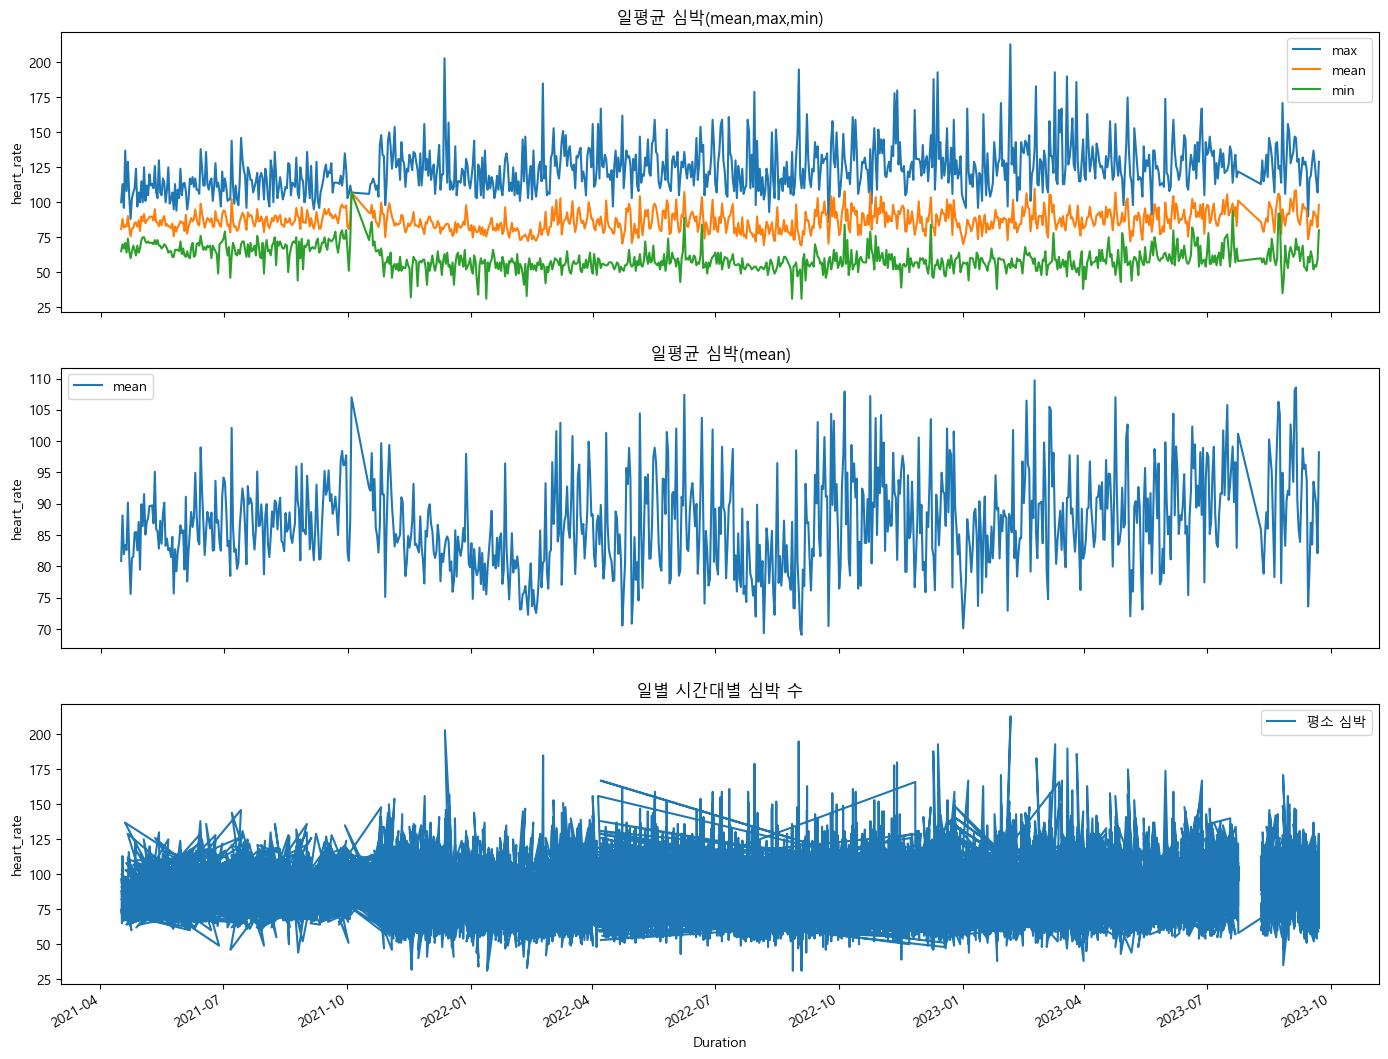

In [56]:
### daily로 변환
daily_stats = tem.groupby(tem['update_time'].dt.date)['heart_rate'].agg(['mean', 'min', 'max'])
print(daily_stats.head(3))

# 앞의 70% 데이터만 학습에 사용
train_df = daily_stats.iloc[:int(len(daily_stats)*0.7)]
test_df = daily_stats.iloc[int(len(daily_stats)*0.7):]

# Figure definition
plt.figure(figsize=(17,14))

### subplot
ax1 = plt.subplot(3,1,1)
plt.title('일평균 심박(mean,max,min)')
plt.plot(daily_stats['max'], label='max')
plt.plot(daily_stats['mean'], label ='mean')
plt.plot(daily_stats['min'], label='min')
plt.xlabel('Duration')
plt.ylabel('heart_rate')
plt.legend()
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))

ax2 = plt.subplot(3,1,2)
plt.title('일평균 심박(mean)')
plt.plot(daily_stats['mean'], label ='mean')
plt.xlabel('Duration')
plt.ylabel('heart_rate')
plt.legend()

ax3 = plt.subplot(3,1,3)
plt.title('일별 시간대별 심박 수')
plt.plot(tem.update_time, tem.heart_rate, label='평소 심박')
plt.xlabel('Duration')
plt.ylabel('heart_rate')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

#### Decomposition

c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


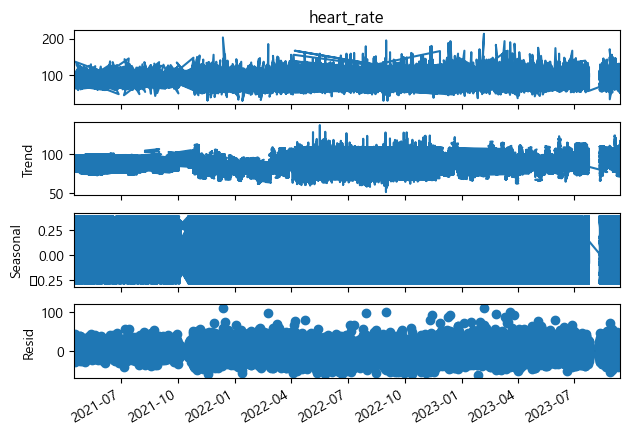

In [63]:
# Convert 'update_time' to datetime
tem.index = pd.to_datetime(tem['update_time'], format='%Y. %m. %d. %H:%M:%S')

# Reset the index to make 'update_time' a regular column
# tem.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(tem['heart_rate'], model='additive', period=12)

result.plot()
plt.gcf().autofmt_xdate()
plt.show()

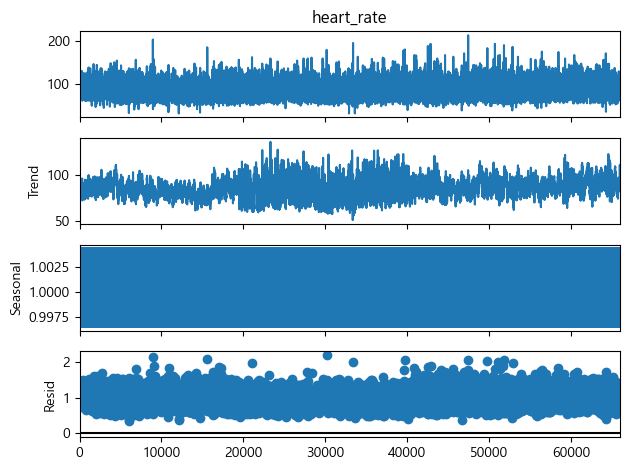

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Reset the index to make 'update_time' a regular column
tem.reset_index(inplace=True)

tem.index

# Convert 'update_time' to datetime
tem['update_time'] = pd.to_datetime(tem['update_time'], format='%Y. %m. %d. %H:%M:%S')

# Reset the index to make 'update_time' a regular column
tem.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(tem['heart_rate'], model='multiplicative', period=12)

result.plot()
plt.show()

c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


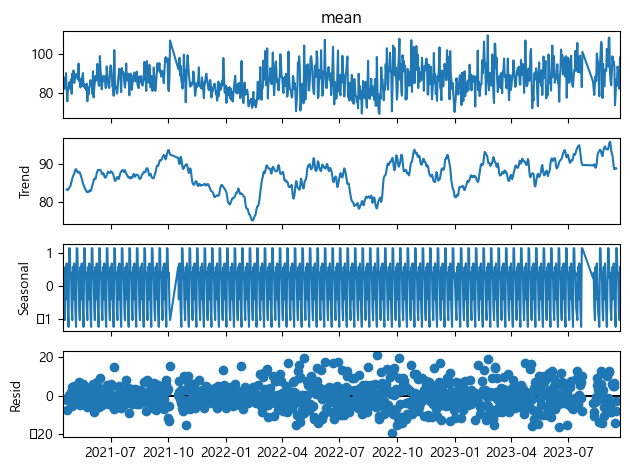

In [58]:
# Reset the index to make 'update_time' a regular column
# daily_stats.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(daily_stats['mean'], model='additive', period=12)

result.plot()
plt.show()

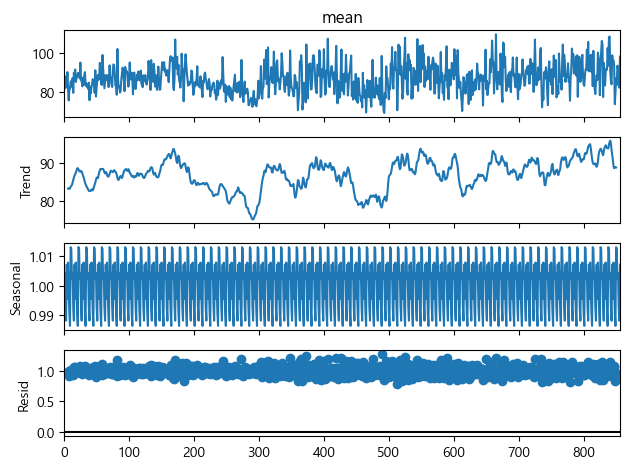

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert 'update_time' to datetime
# daily_stats['ymd'] = pd.to_datetime(daily_stats.index, format='%Y. %m. %d')

# Reset the index to make 'update_time' a regular column
daily_stats.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(daily_stats['mean'], model='multiplicative', period=12)

result.plot()
plt.show()

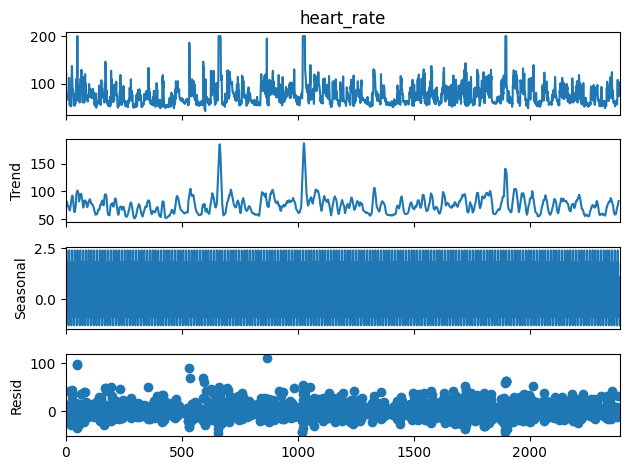

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert 'update_time' to datetime
tem['update_time'] = pd.to_datetime(tem['update_time'], format='%Y. %m. %d. %H:%M:%S')

# Reset the index to make 'update_time' a regular column
tem.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result1 = seasonal_decompose(tem['heart_rate'], model="addictive", period=12)

result1.plot()
plt.show()

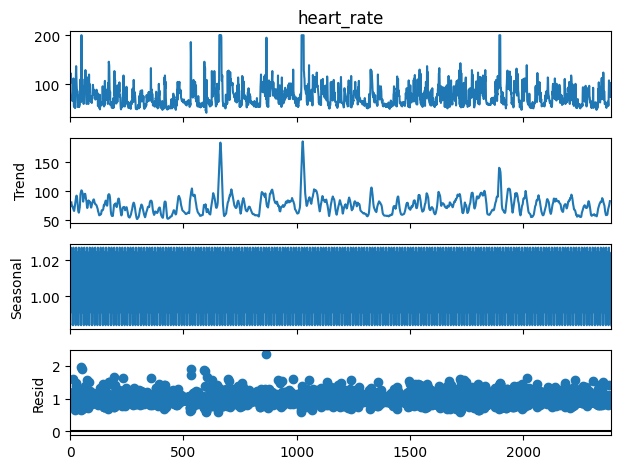

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert 'update_time' to datetime
tem['update_time'] = pd.to_datetime(tem['update_time'], format='%Y. %m. %d. %H:%M:%S')

# Reset the index to make 'update_time' a regular column
tem.reset_index(drop=True, inplace=True)

# Perform seasonal decomposition
result1 = seasonal_decompose(tem['heart_rate'], model="multiplicative", period=12)

result1.plot()
plt.show()

#### tem stats

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ES 모델을 만들어 학습하고 전체 데이터에 대해 예측한다.
# additive는 경향성이 일정함을 의미하고, 경향성 변동폭이 있을 때는 multiplicative를 사용
model = ExponentialSmoothing(
    train_df['heart_rate'], trend='additive', seasonal='additive', seasonal_periods=12).fit()
    
prediction = model.predict(
    start=tem.index[0], end=tem.index[-1])

"""Brutlag Algorithm"""
PERIOD = 12        # The given time series has seasonal_period=12
GAMMA = 0.3684211  # the seasonility component
SF = 1.96          # brutlag scaling factor for the confidence bands.
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

# 실측치와 예측치를 비교하는 자료구조
difference_array = []
dt = []
difference_table = {"actual": tem, "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

# brutlag 알고리즘
# 12개월 이전의 실측/결측 차이에 0.63, 이번달 차이에 0.37 정도의 가중치를 주어 저장
for i in range(len(prediction)):
    diff = tem.iloc[i]-prediction.iloc[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

# 저장된 실측/결측 차이를 예측치의 95% 신뢰구간(1.96)으로 반영하여 Upper/Lower Band 계산
    difference_array.append(diff)
    UB.append(prediction[i]+SF*dt[i])
    LB.append(prediction[i]-SF*dt[i])
    
"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

# 신뢰구간을 벗어나는지 판단하여 normal, anomaly 결정
for i in range(len(tem.index)):
    if ((UB[i] <= tem.iloc[i]).bool() or (LB[i] >= tem.iloc[i]).bool()) and i > PERIOD:
        anomaly_date.append(tem.index[i])
        anomaly.append(tem.iloc[i][0])
    else:
        normal_date.append(tem.index[i])
        normal.append(tem.iloc[i][0])
        
anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

# plotting
plt.figure(figsize=(24,12))
plt.plot(normal.index, normal, 'o', color='green')
plt.plot(anomaly.index, anomaly, 'o', color='red')
plt.plot(tem.index, UB, linestyle='--', color='grey')
plt.plot(tem.index, LB, linestyle='--', color='grey')
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'],fontsize=15)
plt.show()

#### daily stats

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ES 모델을 만들어 학습하고 전체 데이터에 대해 예측한다.
# additive는 경향성이 일정함을 의미하고, 경향성 변동폭이 있을 때는 multiplicative를 사용
model = ExponentialSmoothing(
    train_df['mean'], trend='additive', seasonal='additive', seasonal_periods=12).fit()
    
prediction = model.predict(
    start=tem.index[0], end=tem.index[-1])

"""Brutlag Algorithm"""
PERIOD = 12        # The given time series has seasonal_period=12
GAMMA = 0.3684211  # the seasonility component
SF = 1.96          # brutlag scaling factor for the confidence bands.
UB = []            # upper bound or upper confidence band
LB = []            # lower bound or lower confidence band

# 실측치와 예측치를 비교하는 자료구조
difference_array = []
dt = []
difference_table = {"actual": daily_stats, "predicted": prediction, "difference": difference_array, "UB": UB, "LB": LB}

# brutlag 알고리즘
# 12개월 이전의 실측/결측 차이에 0.63, 이번달 차이에 0.37 정도의 가중치를 주어 저장
for i in range(len(prediction)):
    diff = daily_stats.iloc[i]-prediction.iloc[i]
    if i < PERIOD:
        dt.append(GAMMA*abs(diff))
    else:
        dt.append(GAMMA*abs(diff) + (1-GAMMA)*dt[i-PERIOD])

# 저장된 실측/결측 차이를 예측치의 95% 신뢰구간(1.96)으로 반영하여 Upper/Lower Band 계산
    difference_array.append(diff)
    UB.append(prediction[i]+SF*dt[i])
    LB.append(prediction[i]-SF*dt[i])
    
"""Classification of data points as either normal or anomaly"""
normal = []
normal_date = []
anomaly = []
anomaly_date = []

# 신뢰구간을 벗어나는지 판단하여 normal, anomaly 결정
for i in range(len(daily_stats.index)):
    if ((UB[i] <= daily_stats.iloc[i]).bool() or (LB[i] >= tem.iloc[i]).bool()) and i > PERIOD:
        anomaly_date.append(tem.index[i])
        anomaly.append(tem.iloc[i][0])
    else:
        normal_date.append(tem.index[i])
        normal.append(tem.iloc[i][0])
        
anomaly = pd.DataFrame({"date": anomaly_date, "value": anomaly})
anomaly.set_index('date', inplace=True)
normal = pd.DataFrame({"date": normal_date, "value": normal})
normal.set_index('date', inplace=True)

# plotting
plt.figure(figsize=(24,12))
plt.plot(normal.index, normal, 'o', color='green')
plt.plot(anomaly.index, anomaly, 'o', color='red')
plt.plot(tem.index, UB, linestyle='--', color='grey')
plt.plot(tem.index, LB, linestyle='--', color='grey')
plt.legend(['Normal', 'Anomaly', 'Upper Bound', 'Lower Bound'],fontsize=15)
plt.show()

c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jun99\OneDrive - 계명대학교\바탕 화면\Project\TP\분석 연습\ARIMA\holt-winters\holt\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: unsupported operand type(s) for -: 'Timestamp' and 'float'